# Single task regression training tutorial

In [ ]:
# Imports
import os
import torch
import pandas as pd
import numpy as np
import seqdatasets
import seqdata as sd
import xarray as xr
from eugene import preprocess as pp
from eugene.models.zoo import DeepBind, DeepSTARR
from eugene.models import SequenceModule
from eugene.models.base._metrics import calculate_metric
from eugene import plot as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger

# Configure sdata

In [ ]:
# Load in the 1000 random sequence dataset and preprocess it
sdata = seqdatasets.random1000()
pp.ohe_seqs_sdata(sdata)
pp.make_unique_ids_sdata(sdata)
pp.train_test_split_sdata(sdata)
sdata["ohe_seq"] = sdata["ohe_seq"].transpose("_sequence", "_ohe", "length")
sdata

0it [00:00, ?it/s]

1000it [00:00, 1903.97it/s]


<xarray.Dataset>
Dimensions:     (_sequence: 1000, _ohe: 4, length: 100, id: 1000)
Coordinates:
  * id          (id) <U7 'seq0000' 'seq0001' 'seq0002' ... 'seq0998' 'seq0999'
Dimensions without coordinates: _sequence, _ohe, length
Data variables: (12/24)
    activity_0  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    activity_1  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    activity_2  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    activity_3  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    activity_4  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    activity_5  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    ...          ...
    label_8     (_sequence) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    label_9     (_sequence) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    name        (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    seq         (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    ohe_seq     (_sequence, _ohe, length) uint8 0 0 0 0 1 0 0 ... 1 0 0 0 0 0 0
    train_val   (id) bool False True False False ... False False False False
Attributes:
    max_jitter:  0

# Single task regression

In [ ]:
# Set-up target
sdata["target"] = sdata["activity_0"].load()  # single task regression

In [ ]:
# Split into train and val
train_mask = np.where(sdata["train_val"])[0]
train_sdata = sdata.isel(_sequence=train_mask)
train_dataloader = sd.get_torch_dataloader(
    train_sdata,
    sample_dims=["_sequence"],
    variables=["ohe_seq", "target"],
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    prefetch_factor=None,
    shuffle=True,
    drop_last=True,
    batch_size=128
)
val_sdata = sdata.isel(_sequence=~train_mask)
val_dataloader = sd.get_torch_dataloader(
    val_sdata,
    sample_dims=["_sequence"],
    variables=["ohe_seq", "target"],
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    prefetch_factor=None,
    shuffle=False,
    drop_last=True,
    batch_size=128
)

In [ ]:
# Using a very simple architecture called DeepBind for this example
arch = DeepBind(
    input_len=100,
    output_dim=1
)
arch

DeepBind(
  (conv1d_tower): Conv1DTower(
    (layers): Sequential(
      (0): Conv1d(4, 16, kernel_size=(16,), stride=(1,), padding=valid)
      (1): ReLU()
      (2): Dropout(p=0.25, inplace=False)
    )
  )
  (max_pool): MaxPool1d(kernel_size=85, stride=85, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool1d(kernel_size=(85,), stride=(85,), padding=(0,))
  (dense_block): DenseBlock(
    (layers): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

In [ ]:
# Test out a batch to make sure the architecture works
batch = next(iter(train_dataloader))
seq = batch["ohe_seq"]
target = batch["target"]
outs = arch(seq)
seq.shape, target.shape, outs.shape

(torch.Size([128, 4, 100]), torch.Size([128]), torch.Size([128, 1]))

In [ ]:
# Wrap the architecture in a SequenceModule to allow for easy training
model = SequenceModule(
    arch=arch,
    task="regression",
    arch_name="DeepBind",
    model_name="random1000_DeepBind_regression",
    scheduler="reduce_lr_on_plateau",
    metric="r2score",
)
model.summary()

Model: DeepBind
Sequence length: 100
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type     | Params
------------------------------------------
0 | arch         | DeepBind | 2.1 K 
1 | train_metric | R2Score  | 0     
2 | val_metric   | R2Score  | 0     
3 | test_metric  | R2Score  | 0     
------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)

In [ ]:
# Make sure the models metrics are working properly
calculate_metric(
    metric=model.train_metric,
    metric_name=model.metric_name,
    outs=model(seq),
    y=target
)
model.train_metric.compute()

In [ ]:
# Set-up a logger so we can track training progress
logger = TensorBoardLogger(
    save_dir="/cellar/users/aklie/projects/ML4GLand/EUGENe/notebooks/tests", 
    name="random1000_DeepBind_regression",
    version="0.0.1"
)

In [ ]:
# Set-up a trainer, we usually use a combination of these three callbacks in training. More details on these callbacks can be found here: https://pytorch-lightning.readthedocs.io/en/latest/callbacks.html
callbacks = []
model_checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(logger.save_dir, logger.name, logger.version, "checkpoints"), 
    save_top_k=3, 
    monitor="val_loss_epoch"
)
callbacks.append(model_checkpoint_callback)
early_stopping_callback = EarlyStopping(
    monitor="val_loss_epoch",
    patience=3,
    mode="min",
    verbose=False,
)
callbacks.append(early_stopping_callback)
if model.scheduler is not None:
    callbacks.append(LearningRateMonitor())
trainer = Trainer(
    max_epochs=10, 
    logger=logger, 
    devices=1, 
    accelerator="auto",
    callbacks=callbacks, 
)

In [ ]:
# Fit the model to the data
trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader
)

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type     | Params
------------------------------------------
0 | arch         | DeepBind | 2.1 K 
1 | train_metric | R2Score  | 0     
2 | val_metric   | R2Score  | 0     
3 | test_metric  | R2Score  | 0     
------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The numbe

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


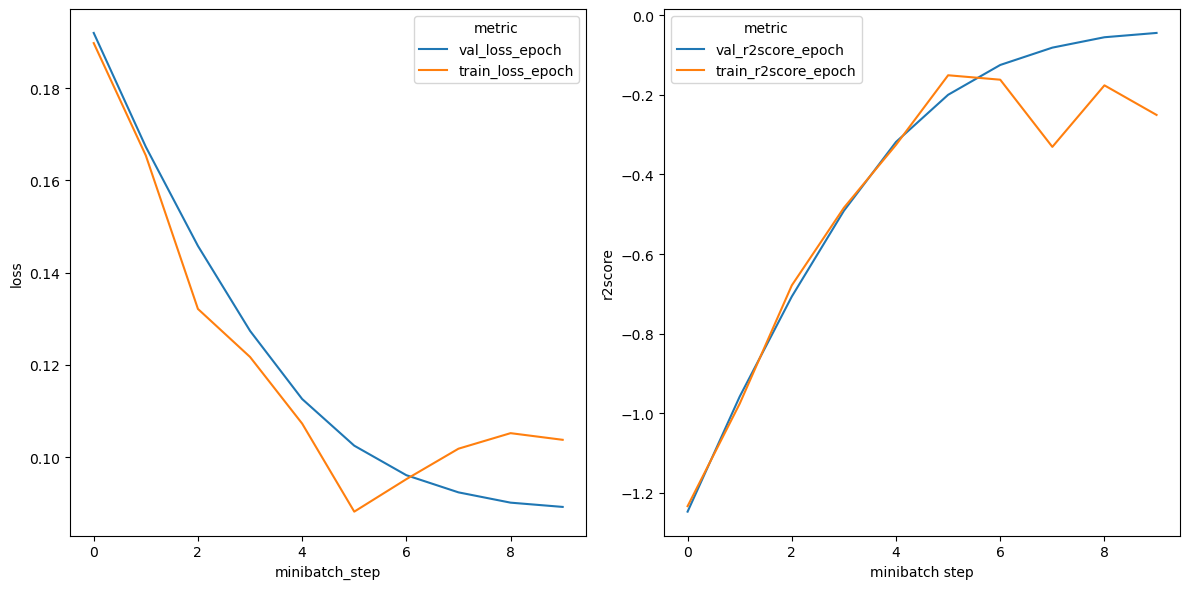

In [ ]:
# Visualize the training progress
pl.training_summary(os.path.join(logger.save_dir, logger.name, logger.version), metric="r2score")

# DONE

---

# Scratch